# Handling missing data
This document (briefly) introduces the concept, categorization, and treatment of missing data.

## Classical categories of missing data
If we know how the missing data are generated, so-called missing data mechanisms, we can take into account why data are missing in data analysis. 

A particularly useful (and wide-known) framework for missingness categorizes missingness into the following three categories (Little and Rudin, 2019):

*Caveat... the category namings are... confusing*

**MCAR (missing completely at random):** how data are missing is independent with any aspect of the data

**MAR (missing at random):** how data are missing depends on **observed** quantities, so-called *predictors, or independent variables*
- e.g., a person with certain characteristics (known) may not answer certain questions on a survey, *imagine reporting salary for different socio-economic classes*
- e.g., for certain inputs, a simulation model may crash or produce nonsensical outputs

**MNAR (missing not at random):** how data are missing depends on the **unobserved** quantities
- e.g., a pollutant sensor can only detect particles that are $> 0.1\mu\mathrm{m}$  
- e.g., storm surges only occur in areas that get below the water level

Understanding the causes of missing data helps designing algorithms to handle missing data.  *However*, in reality, we often do not know the causes, or multiple causes exist in producing a data set.

**Cautionary note:** Where the data are missing matters, i.e., is a response value missing, is a predictor value missing, or do we not know what our analysis questions are yet?

## Treatment of missing data

**Starting with an example of "completing the data"**  

|                            |
|:--------------------------:|
|![gas-a](../img/gas-a.png)  |

|                            |Replace with the mean       |
|:--------------------------:|:--------------------------:|
|![gas-a](../img/gas-a.png)  |![gas-b](../img/gas-b.png)  |

|                            |Replace with the mean + noise|
|:--------------------------:|:--------------------------:|
|![gas-a](../img/gas-a.png)  |![gas-c](../img/gas-c.png)  |

|                            |Replace with the mean + noise + parameter uncertainty|
|:--------------------------:|:--------------------------:|
|![gas-a](../img/gas-a.png)  |![gas-d](../img/gas-d.png)  |

|                            |More information + replace with mean + noise|
|:--------------------------:|:--------------------------:|
|![gas-a](../img/gas-a.png)  |![gas-e](../img/gas-e.png)  |

|                            |Predictive mean matching |
|:--------------------------:|:--------------------------:|
|![gas-a](../img/gas-a.png)  |![gas-f](../img/gas-f.png)  |

**Example of missingness impacting analysis** from Daniel et al. (2012), reproducing Figure 4 in the paper:

|![mar-mnar](../img/mar-mnar.png)|
|:---:|
|Effect of missingness mechanism on data analysis.|


### General rules for treating missing data:  
- Under MCAR, focusing on complete cases or employing imputation methods tend to be sufficient.
- Under MAR, some methods are valid choices:
  - If the missingness is independent of the response *conditional* on the predictor, linear regression is still "valid".
  - Imputation methods tend to introduce biases, depending on the data analysis methods.
- Under MNAR, the missingness should be explicitly modeled.
  - e.g., censored observations in survival analysis.

## Imputation methods
We introduce a (limited) list of imputation methods in this section, using the `titanic` dataset as an example:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.precision', 3)

titanic = sns.load_dataset('titanic', cache=True, data_home='datasets/')

### Identifying missingness
We have covered some basic ways how to identify missingness in the EDA module.  Here is one other option with the help of `missingno`.

In [3]:
# !pip install missingno  
# in case you need to install the package

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
import missingno as msno
# visualization of available/missing data


# hw hint:
# even though info shows that there is missing data, some of them are not actually missing


<Axes: >

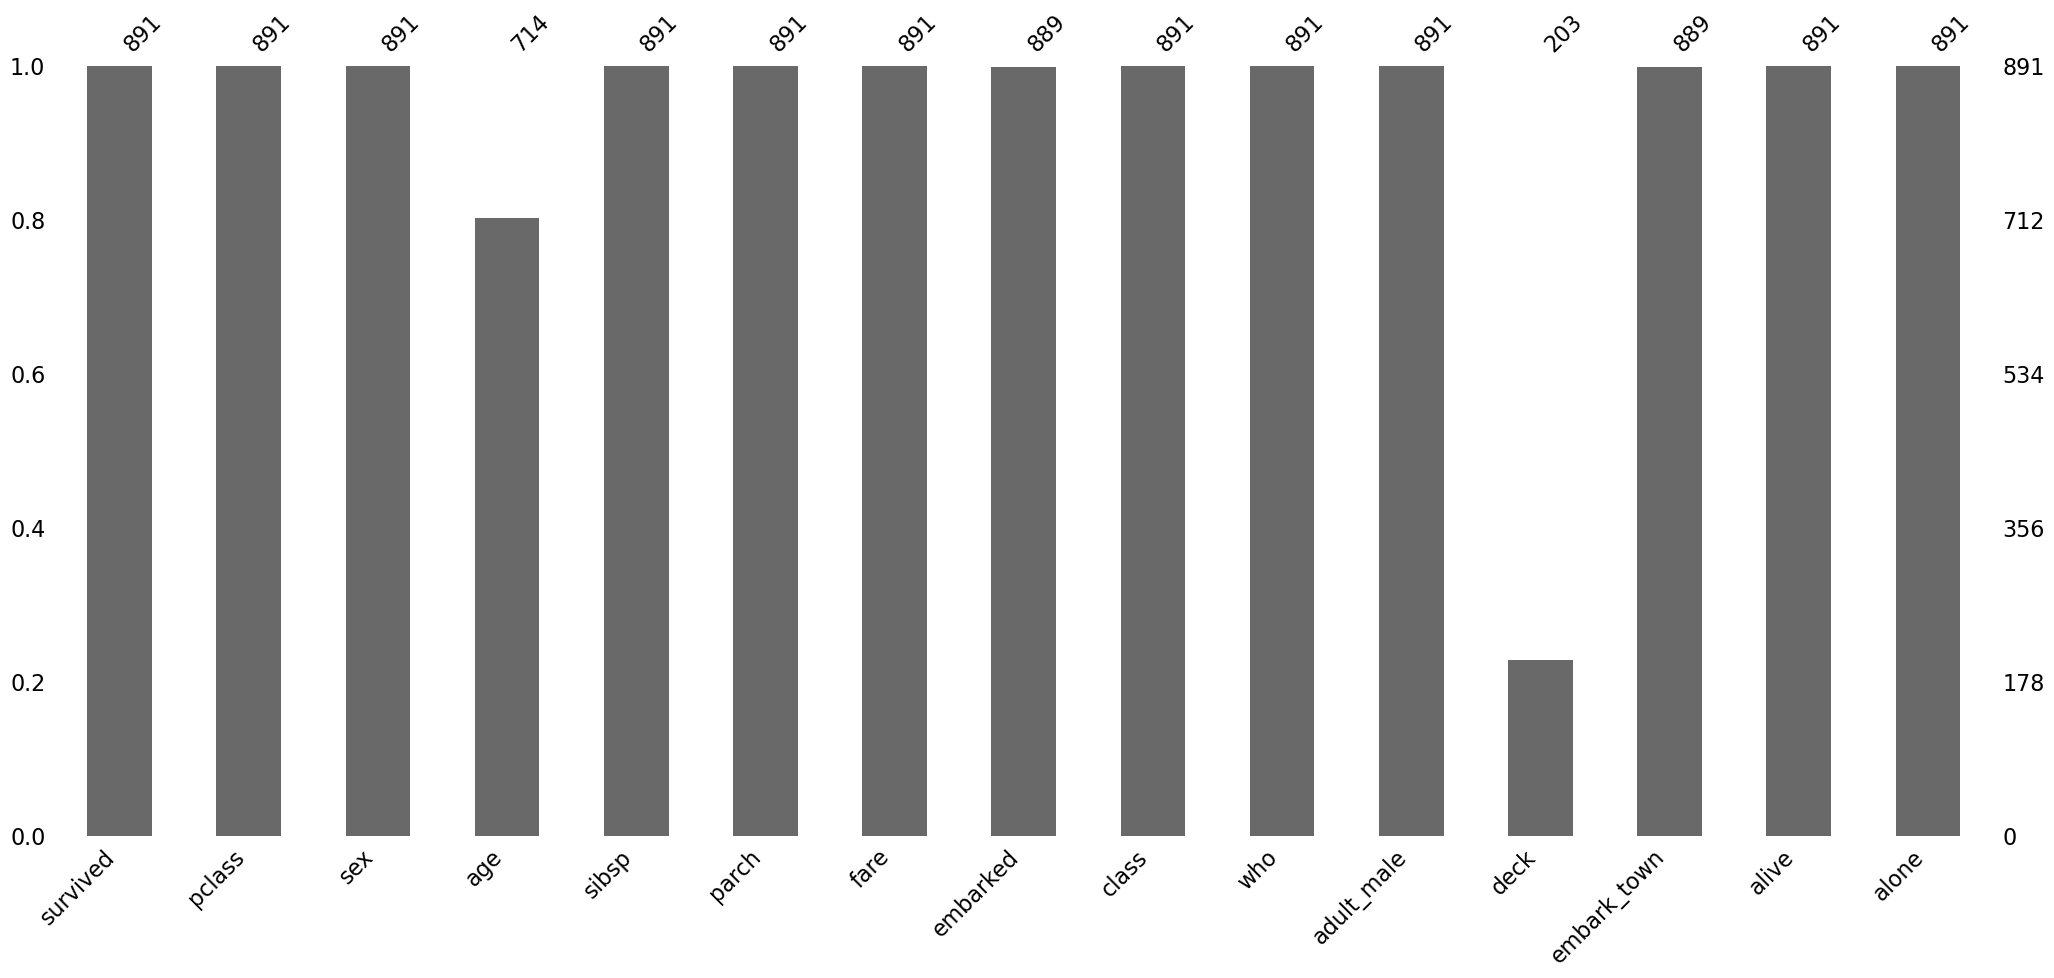

In [5]:
msno.bar(titanic) # shows count of missing values for each column

<Axes: >

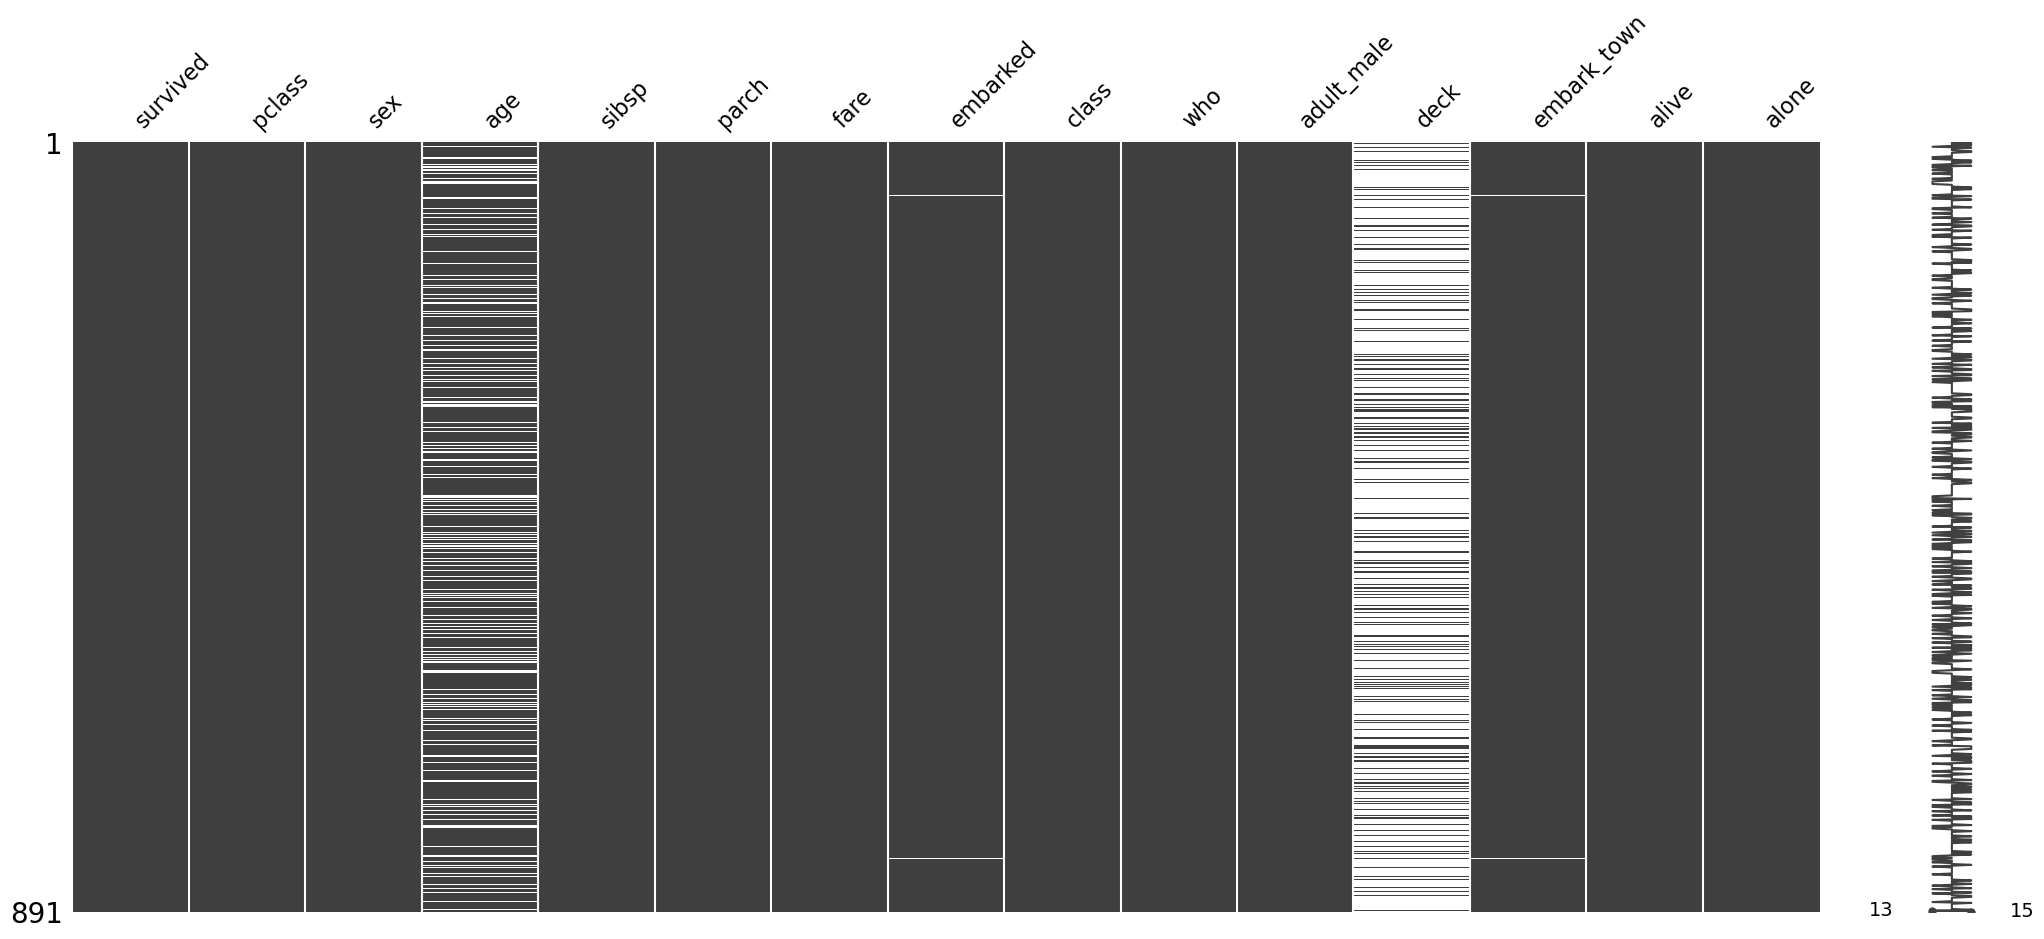

In [6]:
msno.matrix(titanic) # shows where the data is missing

# if you sort by one column, you may be able to see correlation in how they are missing

### Removing data
We have discussed that removing data is typically not ideal, but nothing stops us from doing that...

In [7]:
# retaining titanic dataset with complete data
titanic_agecomp = titanic.dropna(subset=['age'], how='any') # drop nas in a specific column or subset of columns
    # if looking at one column, can do how = any
titanic_agecomp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     714 non-null    int64   
 1   pclass       714 non-null    int64   
 2   sex          714 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        714 non-null    int64   
 5   parch        714 non-null    int64   
 6   fare         714 non-null    float64 
 7   embarked     712 non-null    object  
 8   class        714 non-null    category
 9   who          714 non-null    object  
 10  adult_male   714 non-null    bool    
 11  deck         184 non-null    category
 12  embark_town  712 non-null    object  
 13  alive        714 non-null    object  
 14  alone        714 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 70.2+ KB


In [8]:
# comparing the correlation with / without missing data
corr = titanic.select_dtypes('number').corr()
corr_age_comp = titanic_agecomp.select_dtypes('number').corr()

# changes in correlation matrix with / without age missingness
corr - corr_age_comp

# biggest change is 0.0317 in parch vs sibsp correlation

,survived,pclass,age,sibsp,parch,fare
survived,0.000,0.021,0.0,-0.018,-0.012,-0.011
pclass,0.021,0.000,0.0,0.016,-0.007,0.005
age,0.000,0.000,0.0,0.000,0.000,0.000
sibsp,-0.018,0.016,0.0,0.000,0.031,0.021
parch,-0.012,-0.007,0.0,0.031,0.000,0.011
fare,-0.011,0.005,0.0,0.021,0.011,0.000


In [9]:
# one other possibility (that includes boolean)


# changes in correlation matrix with / without age missingness

### Simple imputation with a constant

In [10]:
# !pip install scikit-learn
from sklearn.impute import SimpleImputer

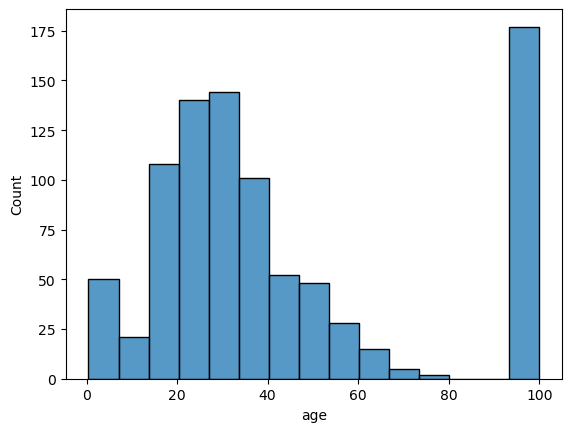

In [11]:
titanic_constant = titanic.copy()

# set constant, completing data
constant_imputer = SimpleImputer(strategy='constant')
    # strategy tells sklearn what value to put in

constant_imputer.fill_value = 100 # setting the constant value to fill with
titanic_constant['age'] = constant_imputer.fit_transform(titanic_constant[['age']]) # here it will transform the data
    # double brackets in pandas dataframe is significant - selecting dataframe or just values


# visualize completed data
sns.histplot(titanic_constant['age'])
plt.show()

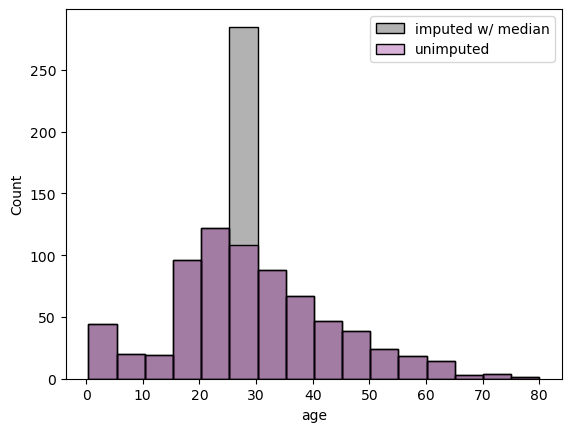

In [12]:
titanic_median = titanic.copy()

# example with median, admitting only numeric columns
median_imputer = SimpleImputer(strategy='median')
titanic_median['age'] = median_imputer.fit_transform(titanic_median[['age']]) # here it will transform the data


# visualize completed data
fig, ax = plt.subplots(1, 1)
sns.histplot(titanic_median['age'], binwidth=5, alpha=0.3, color='k', label='imputed w/ median')
sns.histplot(titanic['age'], binwidth=5, alpha=0.3, color='purple', label='unimputed')
ax.legend()

### Multiple imputation
Multiple imputation is a technique to generate multiple realizations of imputation values, often modeled by a probability distribution.

One method is the multiple imputation by chained equations, or MICE. `miceforest` uses LightBGM as its training algorithm for MICE.

In [13]:
#pip install -U miceforest plotnine

In [14]:
import miceforest as mf

# miceforest requires a real matrix. 
# For illustrative purposes, we only use the numerical columns.

# set up a kernel to produce `num_datasets` imputed datasets

num_datasets = 4 # will produce 4 different possible datasets
kernel = mf.ImputationKernel(
    titanic.select_dtypes('number'), # selecting only the numeric columns
    num_datasets=num_datasets,
    save_all_iterations_data=False, # if u just want the results
    random_state=1
)

In [15]:
# run the MICE algorithm
kernel.mice(iterations=10)

In [16]:
# retrieve completed data
titanic_mf = kernel.complete_data

# kernel.plot_imputed_distributions() #see whether it resembles original data


In [17]:
# code for plotting mice completed dataset
def plot_hist(kernel, completed_titanic, original_titanic, num_plot):
    num_datasets = kernel.num_datasets
    num_plot = min(num_datasets, num_plot)
    for k in range(num_plot):  # 1, 2, 3, num_datasets
        sns.histplot(completed_titanic(dataset=k)['age'], binwidth=5, stat='probability', color='k', label='imputed sample', alpha=0.3)
    
    sns.histplot(original_titanic['age'], binwidth=5, stat='probability', color='purple', label='unimputed', alpha=0.2)
    
    plt.title('{:d} realizations of imputed age'.format(num_plot))
    plt.legend()
    plt.tight_layout()
    plt.show()

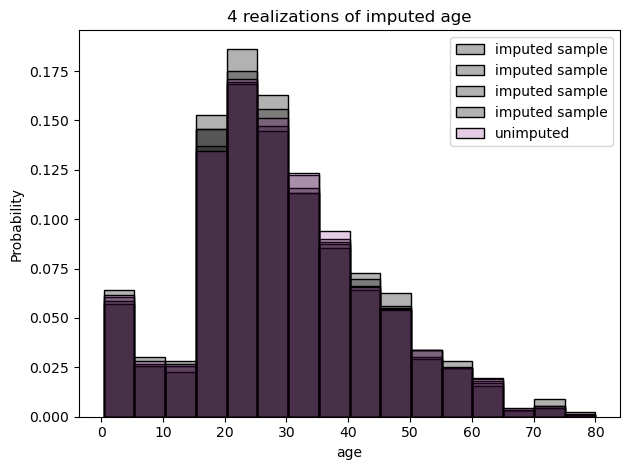

In [18]:
# retrieving each imputed dataset (recall that M in MICE means multiple)
plot_hist(kernel=kernel, completed_titanic=titanic_mf, original_titanic=titanic, num_plot=4)

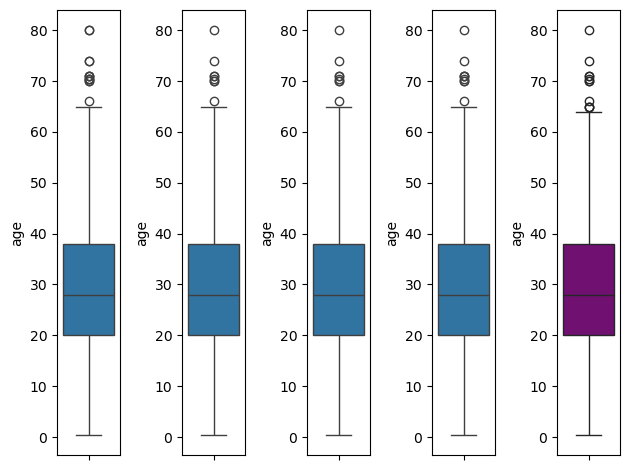

In [19]:
# comparing the original and imputed dataset
fig, ax = plt.subplots(ncols=5)

for k, axi in enumerate(ax.flatten()):
    if k < num_datasets:
        sns.boxplot(titanic_mf(dataset=k)['age'], ax=axi)
    else:
        sns.boxplot(titanic['age'], ax=axi, color='purple')

plt.tight_layout()

we want multiple datasets so we can have a robust analyses
- having a profile of what the data analyses look like requires multiple generated datasets
- has to do with consistency and downstream analyses

In [20]:
# Generate more datasets 

# Visualize the result variable density/histogram

### Predictive mean matiching (MICE) [Last figure in the gas consumption example]

In [21]:
kernel_pmm = mf.ImputationKernel(
    titanic.select_dtypes('number'),
    num_datasets=num_datasets,
    mean_match_candidates = 8, # go into datasets and pick out which candidates are closest to predictive mean
    save_all_iterations_data=False,
    random_state=1
)

In [22]:
kernel_pmm.mice(iterations = 10)

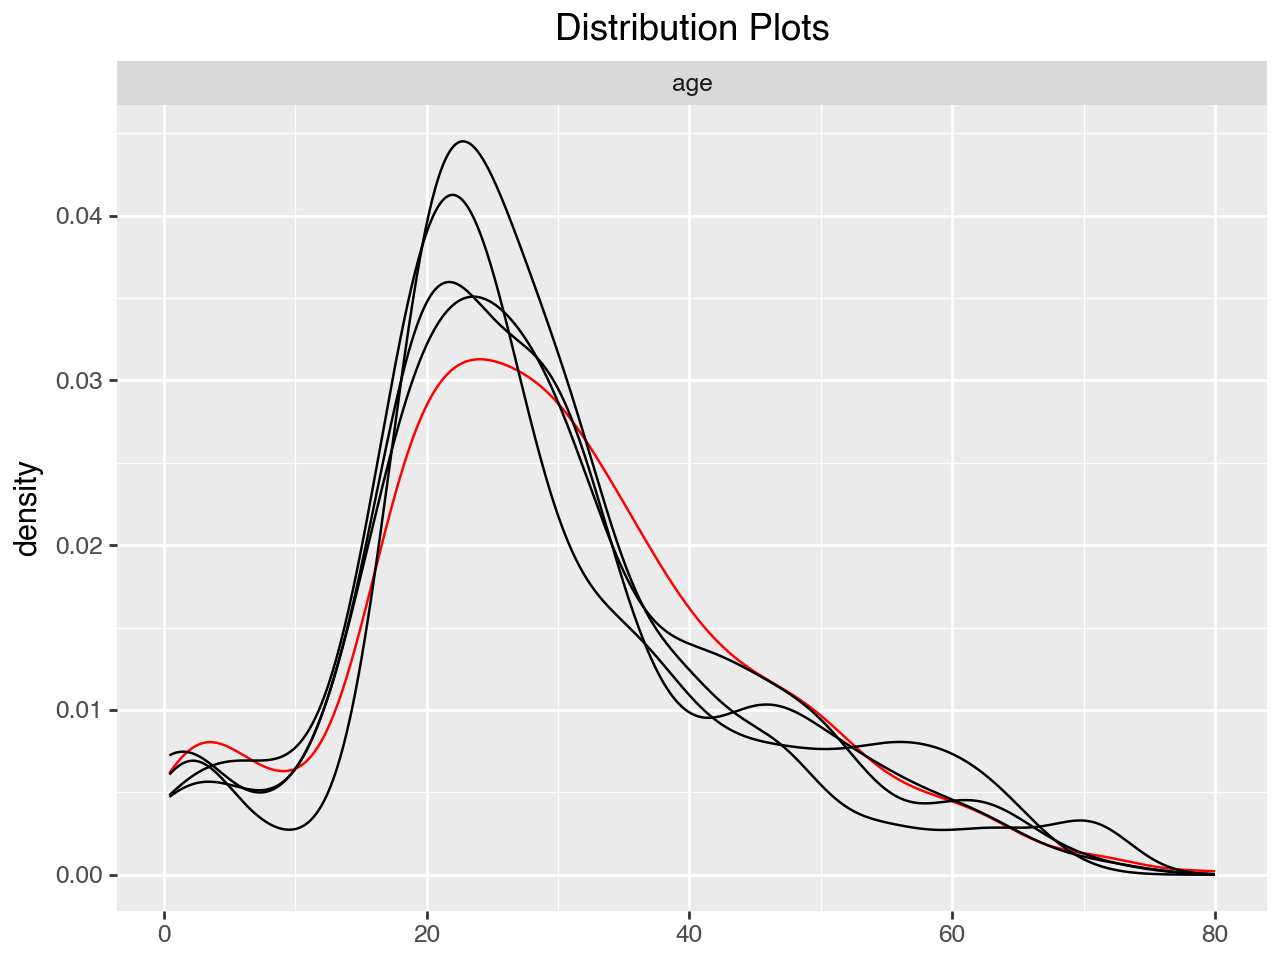

In [23]:
kernel_pmm.plot_imputed_distributions()

### $k$ Nearest Neighbor

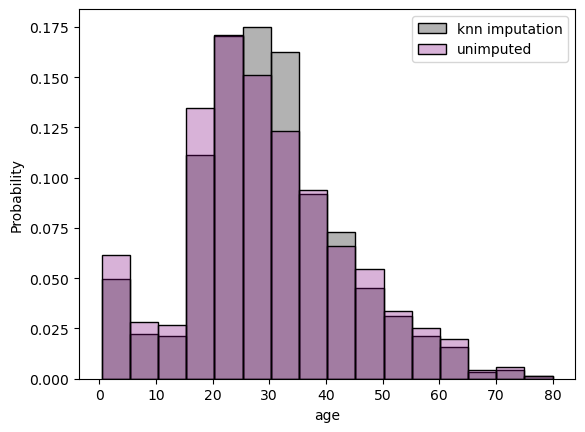

In [24]:
titanic_knn = titanic.select_dtypes('number').copy()

from sklearn.impute import KNNImputer
# set up imputing for KNN

knn_imputer = KNNImputer(n_neighbors=10)

titanic_knn_df = pd.DataFrame(knn_imputer.fit_transform(titanic_knn), columns=titanic_knn.columns)

# visualize completed data
fig, ax = plt.subplots(1, 1)
sns.histplot(titanic_knn_df['age'], binwidth=5, stat='probability', alpha=0.3, color='k', label='knn imputation')
sns.histplot(titanic['age'], binwidth=5, stat='probability', alpha=0.3, color='purple', label='unimputed')
ax.legend()
plt.show()

# (Exercise) Imputation of tips

Consider the `taxis` dataset from seaborn, practice the imputation methods on the `tip` column for the dataset `subtaxi_missing`, given below:
1. Complete the data using         
    i. mean simple imputation,
    ii. median simple imputation,
    iii. k-nearest neighbor, and
    iv. predictive mean matching.
2. Compute the root mean squared error for each imputation method (because you know the truth).  Which one is the best in this case?
3. Examine the correlation matrix among the numerical columns.  Which methods preserve the correlation among variables?

In [25]:
import seaborn as sns

taxi = sns.load_dataset('taxis')
taxi.info()
subtaxi = taxi.loc[:, ['passengers', 'distance', 'fare', 'tip', 'tolls', 'total']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup           6433 non-null   datetime64[ns]
 1   dropoff          6433 non-null   datetime64[ns]
 2   passengers       6433 non-null   int64         
 3   distance         6433 non-null   float64       
 4   fare             6433 non-null   float64       
 5   tip              6433 non-null   float64       
 6   tolls            6433 non-null   float64       
 7   total            6433 non-null   float64       
 8   color            6433 non-null   object        
 9   payment          6389 non-null   object        
 10  pickup_zone      6407 non-null   object        
 11  dropoff_zone     6388 non-null   object        
 12  pickup_borough   6407 non-null   object        
 13  dropoff_borough  6388 non-null   object        
dtypes: datetime64[ns](2), float64(5), int64(

In [26]:
import numpy as np
# create missingness
np.random.seed(42)
mask1 = subtaxi.total > 25
mask2 = np.random.rand(subtaxi.shape[0]) < 0.7

subtaxi_missing = subtaxi.copy()
subtaxi_missing.loc[mask1 & mask2, 'tip'] = np.nan

<Axes: >

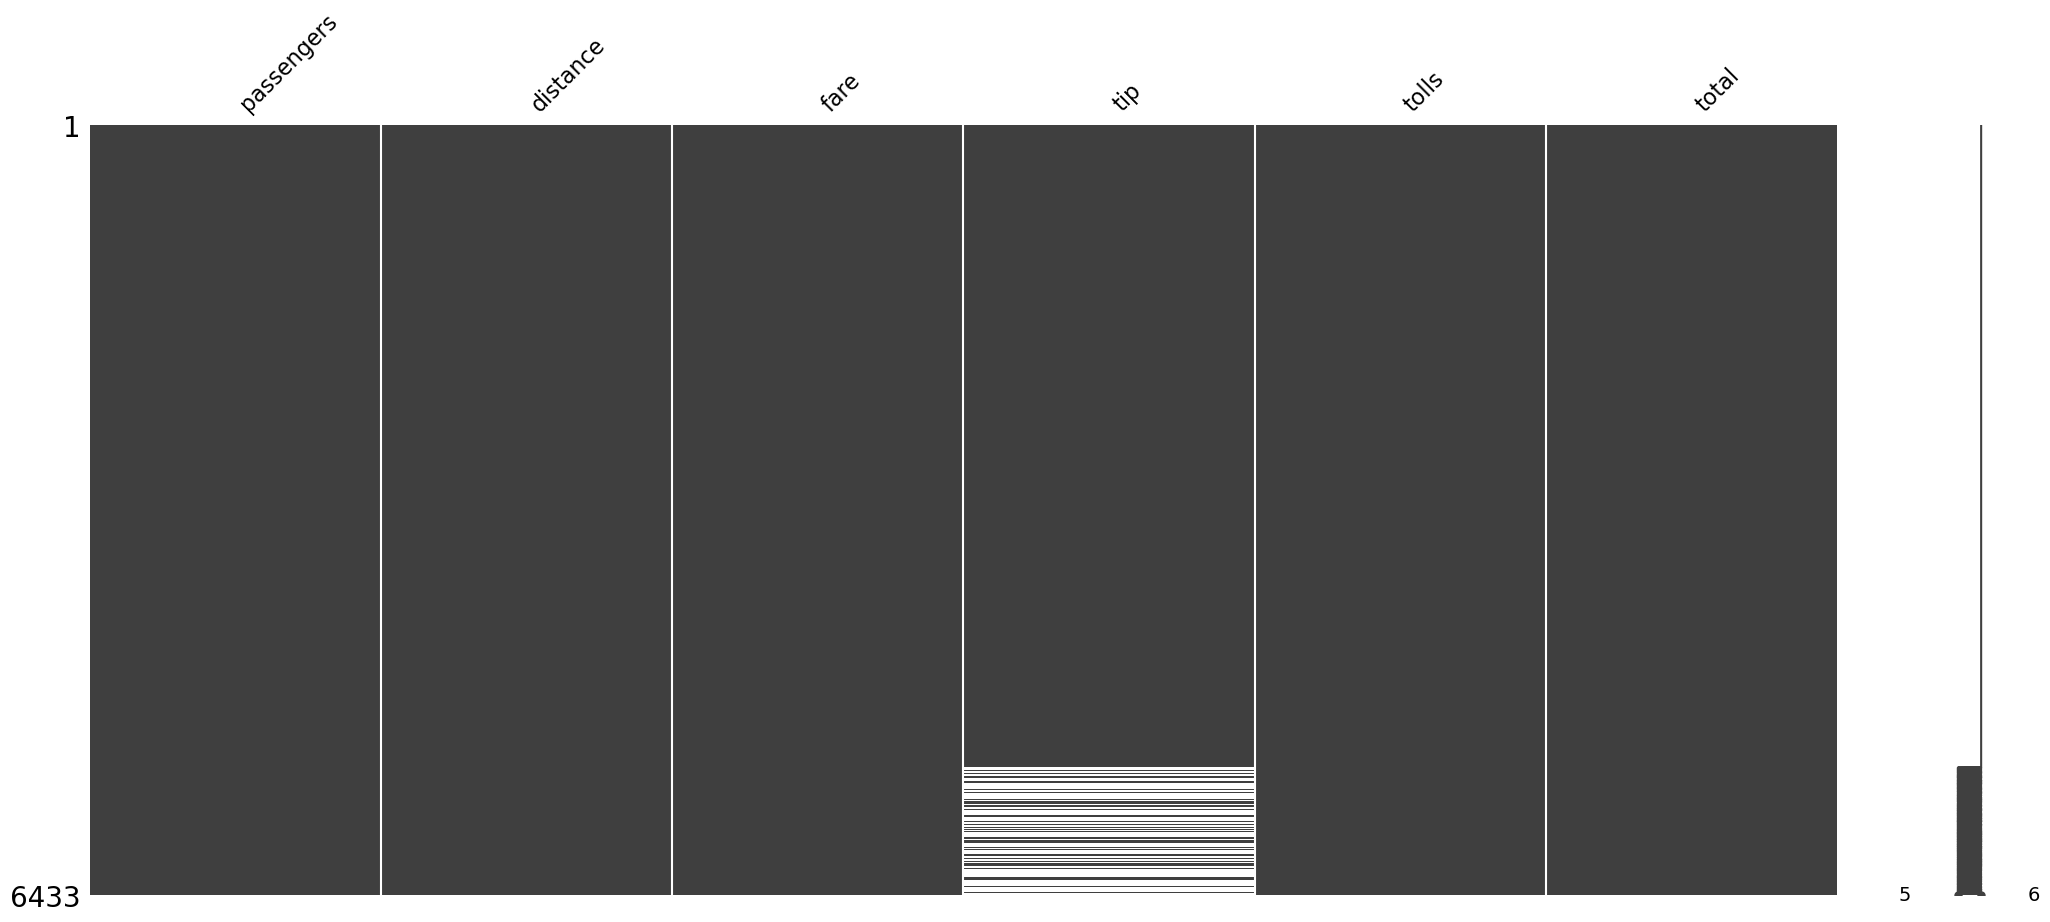

In [27]:
msno.matrix(subtaxi_missing.sort_values('total'))

1. Complete the data using         
    i. mean simple imputation,
    ii. median simple imputation,
    iii. k-nearest neighbor, and
    iv. predictive mean matching.
2. Compute the root mean squared error for each imputation method (because you know the truth).  Which one is the best in this case?
3. Examine the correlation matrix among the numerical columns.  Which methods preserve the correlation among variables?

In [28]:
# setting up and creating imputations

taxi_median = subtaxi_missing.copy()
median_imputer = SimpleImputer(strategy='median')
taxi_median['tip'] = median_imputer.fit_transform(taxi_median[['tip']])


taxi_mean = subtaxi_missing.copy()
mean_imputer = SimpleImputer(strategy='mean')
taxi_mean['tip'] = median_imputer.fit_transform(taxi_mean[['tip']])


taxi_knn = subtaxi_missing.copy()
knn_imputer = KNNImputer(n_neighbors=4)
taxi_knn = pd.DataFrame(knn_imputer.fit_transform(taxi_knn), columns=taxi_knn.columns)

In [60]:
taxi_pmm = subtaxi_missing.copy()
pmm_kernel = mf.ImputationKernel(
    taxi_pmm.select_dtypes('number'),
    num_datasets=10,
    mean_match_candidates = 6, # go into datasets and pick out which candidates are closest to predictive mean
    save_all_iterations_data=False,
    random_state=1
)
pmm_kernel.mice(iterations=10)
taxi_pmm = pmm_kernel.complete_data()

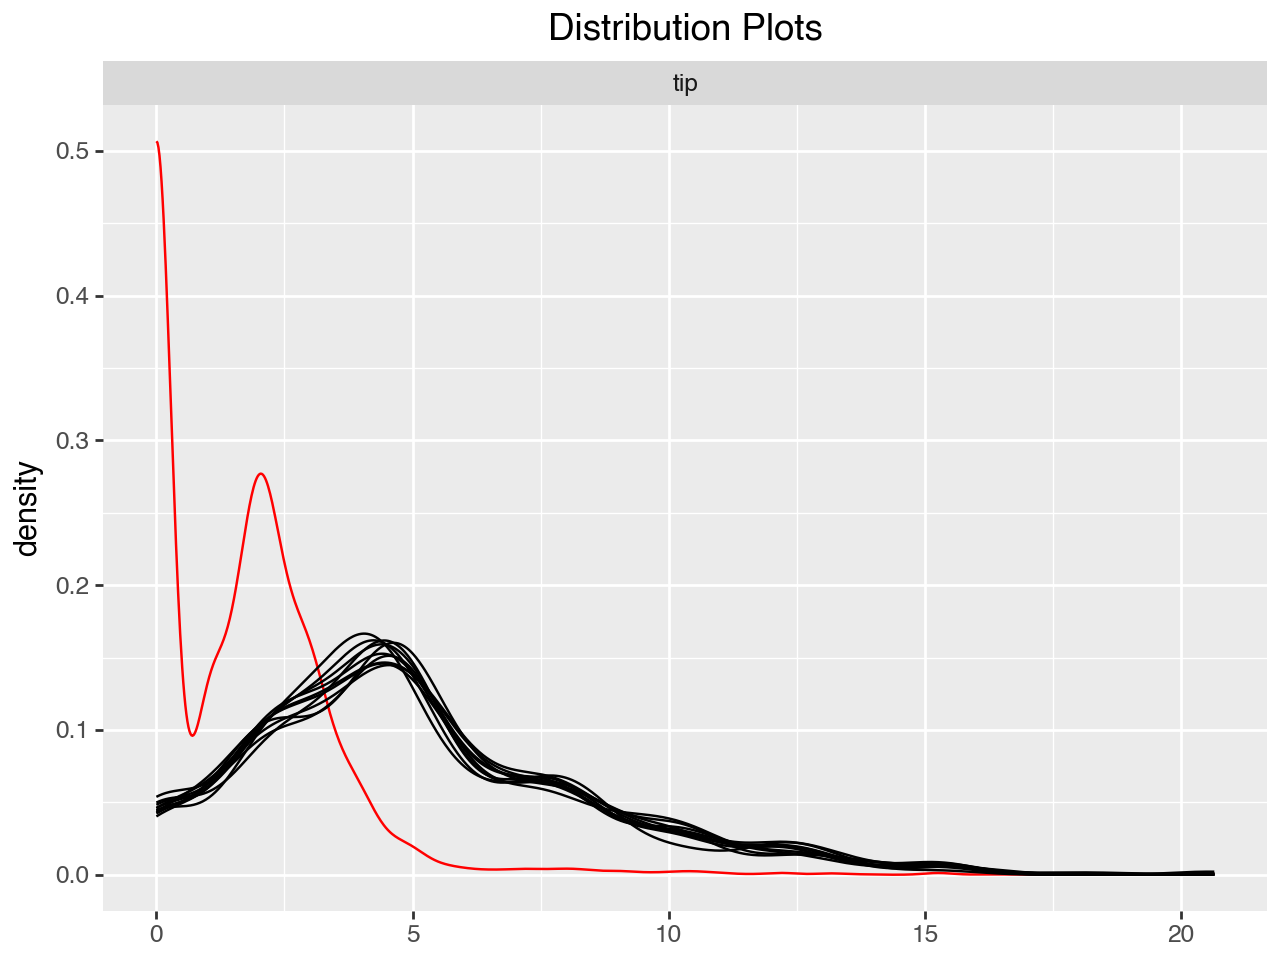

In [61]:
pmm_kernel.plot_imputed_distributions()

In [62]:
# calculating rmse

tips_true = subtaxi['tip']

def rmse(original, imputed):
    return np.sqrt(np.nanmean((original - imputed) ** 2))

rmse_median = rmse(tips_true, taxi_median['tip'])
rmse_mean = rmse(tips_true, taxi_median['tip'])
rmse_knn = rmse(tips_true, taxi_knn['tip'])
rmse_pmm = rmse(tips_true, taxi_pmm['tip'])

print(f'RMSE for Median Imputation: {rmse_median:.3f}')
print(f'RMSE for Mean Imputation: {rmse_mean:.3f}')
print(f'RMSE for KNN Imputation: {rmse_knn:.3f}')
print(f'RMSE for PMM Imputation: {rmse_pmm:.3f}')


RMSE for Median Imputation: 1.804
RMSE for Mean Imputation: 1.804
RMSE for KNN Imputation: 0.682
RMSE for PMM Imputation: 0.915


The imputation method with the lowest RMSE is KNN with 0.682. PMM is also significantly lower than mean or median.

In [32]:
corr_true = subtaxi.select_dtypes('number').corr()
corr_true

,passengers,distance,fare,tip,tolls,total
passengers,1.000,0.009,0.008,0.021,-0.003,0.016
distance,0.009,1.000,0.920,0.453,0.635,0.905
fare,0.008,0.920,1.000,0.489,0.609,0.974
tip,0.021,0.453,0.489,1.000,0.414,0.646
tolls,-0.003,0.635,0.609,0.414,1.000,0.683
total,0.016,0.905,0.974,0.646,0.683,1.000


In [33]:
### comparison of correlations
corr_true = subtaxi.select_dtypes('number').corr()
corr_median = taxi_median.select_dtypes('number').corr()
corr_mean = taxi_mean.select_dtypes('number').corr()
corr_knn = taxi_knn.select_dtypes('number').corr()
corr_pmm = taxi_pmm.select_dtypes('number').corr()

# subtract
corr_diff_median = corr_true - corr_median
corr_diff_mean = corr_true - corr_mean
corr_diff_knn = corr_true - corr_knn
corr_diff_pmm = corr_true - corr_pmm

In [34]:
corr_true

,passengers,distance,fare,tip,tolls,total
passengers,1.000,0.009,0.008,0.021,-0.003,0.016
distance,0.009,1.000,0.920,0.453,0.635,0.905
fare,0.008,0.920,1.000,0.489,0.609,0.974
tip,0.021,0.453,0.489,1.000,0.414,0.646
tolls,-0.003,0.635,0.609,0.414,1.000,0.683
total,0.016,0.905,0.974,0.646,0.683,1.000


In [35]:
corr_diff_median

,passengers,distance,fare,tip,tolls,total
passengers,0.000e+00,0.000,0.000,-2.086e-04,0.000,0.000
distance,0.000e+00,0.000,0.000,2.214e-01,0.000,0.000
fare,0.000e+00,0.000,0.000,2.352e-01,0.000,0.000
tip,-2.086e-04,0.221,0.235,0.000e+00,0.209,0.272
tolls,0.000e+00,0.000,0.000,2.087e-01,0.000,0.000
total,0.000e+00,0.000,0.000,2.725e-01,0.000,0.000


In [36]:
corr_diff_mean

,passengers,distance,fare,tip,tolls,total
passengers,0.000e+00,0.000,0.000,-2.086e-04,0.000,0.000
distance,0.000e+00,0.000,0.000,2.214e-01,0.000,0.000
fare,0.000e+00,0.000,0.000,2.352e-01,0.000,0.000
tip,-2.086e-04,0.221,0.235,0.000e+00,0.209,0.272
tolls,0.000e+00,0.000,0.000,2.087e-01,0.000,0.000
total,0.000e+00,0.000,0.000,2.725e-01,0.000,0.000


In [37]:
corr_diff_knn

,passengers,distance,fare,tip,tolls,total
passengers,0.000e+00,0.000,0.000,-2.266e-04,0.000,0.000
distance,0.000e+00,0.000,0.000,-4.213e-02,0.000,0.000
fare,0.000e+00,0.000,0.000,-3.364e-02,0.000,0.000
tip,-2.266e-04,-0.042,-0.034,0.000e+00,-0.044,-0.028
tolls,0.000e+00,0.000,0.000,-4.420e-02,0.000,0.000
total,0.000e+00,0.000,0.000,-2.823e-02,0.000,0.000


In [90]:
corr_diff_pmm

,passengers,distance,fare,tip,tolls,total
passengers,0.000,0.000,0.000,0.001,0.000,0.000
distance,0.000,0.000,0.000,-0.074,0.000,0.000
fare,0.000,0.000,0.000,-0.077,0.000,0.000
tip,0.001,-0.074,-0.077,0.000,-0.092,-0.062
tolls,0.000,0.000,0.000,-0.092,0.000,0.000
total,0.000,0.000,0.000,-0.062,0.000,0.000


KNN and PMM seem to preserve the correlation between the features the best of all the imputation methods. KNN seems to improve on PMM by a small amount for some. 

### crops

Investigate the dataset for crop recommendation.

- Create a function that can induce some missingness (start with missing completely at random).
- Create a logistic regression model (or any prediction model) for the column label.
- Create a function that can take in an “imputation type” argument and return an imputed dataset.
- Compare the different imputation types in prediction accuracy of label and correlation conservation.

In [47]:
import pandas as pd
crop = pd.read_csv('https://raw.githubusercontent.com/mosesyhc/de300-2026wi/refs/heads/main/datasets/crop_recommendation.csv')


In [48]:
crop

,"N,P,K,temperature,humidity,ph,rainfall,label"
0,"90,42,43,20.87974371,82.00274423,6.50298529200..."
1,"85,58,41,21.77046169,80.31964408,7.038096361,2..."
2,"60,55,44,23.00445915,82.3207629,7.840207144,26..."
3,"74,35,40,26.49109635,80.15836264,6.980400905,2..."
4,"78,42,42,20.13017482,81.60487287,7.628472891,2..."
...,...
2195,"107,34,32,26.77463708,66.4132686,6.78006386,17..."
2196,"99,15,27,27.41711238,56.63636248,6.086922359,1..."
2197,"118,33,30,24.13179691,67.22512329,6.362607851,..."
2198,"117,32,34,26.2724184,52.12739421,6.758792552,1..."


In [ ]:
# create function to induce missingness

def missingness(df):

    missing_df = df.copy()

    # missing completely at random

    mask1 = ...
    mask2 = ...

    return missing_df

# References

- Daniel, R. M., Kenward, M. G., Cousens, S. N., & De Stavola, B. L. (2012). Using causal diagrams to guide analysis in missing data problems. Statistical methods in medical research, 21(3), 243-256.  
- Hastie, T., Mazumder, R., Lee, J. D., & Zadeh, R. (2015). Matrix completion and low-rank SVD via fast alternating least squares. The Journal of Machine Learning Research, 16(1), 3367-3402.  
- Little, R. J., & Rubin, D. B. (2019). Statistical analysis with missing data. John Wiley & Sons.  
- [Van Buuren, S. (2012). Flexible imputation of missing data. Boca Raton, FL: CRC press.](https://stefvanbuuren.name/fimd)

# Some useful additional resources

- [Gary King: Analyzing Incomplete Political Science Data](https://gking.harvard.edu/files/evil.pdf)
- Zangerle, E., & Bauer, C. (2022). Evaluating recommender systems: survey and framework. ACM Computing Surveys, 55(8), 1-38.